run in the mexico conda env for compatibility with snellius

In [159]:
import sqlite3
import pandas as pd
import pathlib
import json
import re
from tqdm import tqdm
from bertopic import BERTopic
import pickle
import bz2
from tqdm.contrib.concurrent import process_map
from collections import defaultdict
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import arviz as az
from itertools import cycle
from scipy.stats import bernoulli
import random
import graphviz
from functools import reduce
from operator import concat
import cloudpickle
import dill


In [160]:
!pip install graphviz

In [161]:
import sys
sys.version

'3.10.4 (main, Mar 31 2022, 03:37:37) [Clang 12.0.0 ]'

# helper functions

In [162]:
def plot_posterior_trace(trace):
    """ Plot posterior parameter distributions, i.e., P(parameter=value | data)
    """
    var_names = [name for name in trace.posterior]
    for i, var_name in enumerate(var_names):
        az.plot_trace(data=trace, var_names=[var_name])

def plot_posterior_estimates(trace, size=1000, kind='kde'):
    """ Plot posterior parameter distributions, i.e., P(parameter=value | data)
    """

    var_names = [name for name in trace.posterior]
    fig, axs = plt.subplots((len(var_names)))
    fig.tight_layout()

    # sample the trace
    sample_subset = az.extract(trace, num_samples=size)
    
    d = {}
    for i, (var_name) in enumerate(var_names):

        # get posterior samples wrt., var_name 
        draw_samples = sample_subset[var_name]

        # get random samples of 
        plt.sca(axs[i])
        az.plot_dist(draw_samples, kind=kind, label=f'{var_name}')
        d[var_name] = draw_samples

    return d
        
def plot_posterior_predictive_checks(model, trace, size=1000):
    """ Plot (hist) predictions of estimand (based on parameter posteriors) against the observed 
    """
    
    # get estimand predictions based on param posteriors
    with model: 
        post_pred: arviz.data.inference_data.InferenceData = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
        # don't add to trace
            
    # for each estimate record (predictions, observed) for each estimand
    d = {}
    n = len(post_pred.posterior_predictive)
    for i, name in enumerate(post_pred.posterior_predictive):
        
        # get a random sample (with replacement) of predictions from stack predictions accross draws and chains
        p_dims = post_pred.posterior_predictive[name].dims
        p: np.ndarray = np.random.choice(post_pred.posterior_predictive[name].stack(sample=p_dims).to_numpy(), size, replace=True)
            
#         p: xarray.core.dataarray.DataArray = post_pred.posterior_predictive[name].mean(sample=('chain', 'draw'))  
            
        o: np.ndarray = post_pred.observed_data[name].to_numpy()
        d[name] = (p,o)  # (predicted, observed)
        
    # plot observed vs predicted for each estimand
    fig, axs = plt.subplots(n)
    fig.tight_layout(h_pad=4)
    for i, name in enumerate(post_pred.posterior_predictive):

        if n > 1:
            plt.sca(axs[i])
        else:
            pass
        plt.hist([d[name][0], d[name][1]], label=['predicted', 'observed'], density=True)
        plt.xlabel(name)
        plt.ylabel("density")
        plt.legend()
        plt.xticks(rotation=90)
        
    return d
    
def plot_posterior_estimates_contrast(trace, pairs=[], kind='kde'):
    """ For each param1, param2 pair in 'pairs' ...
            plot distribution of corresponding (param1 - param2) estimates.
            
        Note: also return each pair contrast. I.e., returned[i] is a contrast dist. corresponding to pairs[i]
    """
    contrasts = []
    
    fig, axs = plt.subplots(1)
    fig.tight_layout()
    
    # plot contrasts
    for i, (x,y) in enumerate(pairs):
        
        pc = (trace.posterior[x] - trace.posterior[y]).stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        az.plot_dist(pc, color=f'C{i}', kind=kind, label=f'{x}-{y}')
        
        contrasts.append(pc)
        
    plt.xlabel(f"posterior estimates contrast")
    plt.ylabel("density")
    plt.legend()
        
    return contrasts
        
        
def plot_posterior_predictions_contrast(model, trace, pairs=[], size=1000)->list:
    """ For each estimand1, estimand2 'pair' in 'pairs' ...
            plot the distribution of corresponding (estimand1 - estimand2) samples
    
        Note: also return each contrast. I.e., returned[i] is a contract dist. corresponding to pairs[i]
        where returned 1 is a 1D numpy array
    """
    
    returned=[]
    
    # get posterior predictions
    with model:
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
    preds = {name: post_pred.posterior_predictive[name] for name in post_pred.posterior_predictive} 
    # NOTE: e.g., preds[var].shape=(chains, draws, datapoints)
        
    fig, axs = plt.subplots(len(pairs))
    fig.tight_layout()
    
    
    for i, (name1, name2) in enumerate(pairs):
        
        # if more than one plot, set current
        try:
            plt.sca(axs[i])
        except:
            pass
        
        # Note xarray of dims (chain, draw, m) - x array of dims (chain, draw, f) would yield an
        # an array of dims (chain, draw, m, f) i.e., all possible differences accross all m,f permutations for a draw, chain combo
        # this becomes very slow for larger samples ... hence we just randomnly select some ... and take the diff.
        
        # plot contrast
        sample1 = np.random.choice(preds[name1].stack(sample=(preds[name1].dims)).to_numpy(), size, replace=True)
        sample2 = np.random.choice(preds[name2].stack(sample=(preds[name2].dims)).to_numpy(), size, replace=True)
        ppc = sample1 - sample2
        az.plot_dist(ppc, color='k', plot_kwargs=dict(linewidth=3))
        plt.xticks(rotation=90)
        
        plt.xlabel(f"({name1}-{name2})\nposterior prediction contrast")
        plt.ylabel("density")
        plt.legend()
        
        returned.append(ppc)
        
    return returned

def compat_interval(d: np.ndarray, CI=0.89)->tuple[float]:
    lb = (1-CI)/2
    ub = CI+lb
    return '%.3E' % np.quantile(d, lb), '%.3E' % np.quantile(d, ub)



# Plausible causal models

    quote from reference position paper by kiritchenko ... "Moreover, aporophobia often aggravates
    intersectional bias (e.g., it is not the same to be a rich woman from an ethnic minority than a poor
    woman from the same ethnic group)"

    I.e., N(group + poor context) > N(group alone), i.e., poverty contexts aggrevate negative bias
    

## foundational assumptions**
* the poor may be stigmatized for being poor;
* certain people groups may be stigmatized for being that group;
* certain topics act as vehicles for stigmatization;

## supposition 1

There is no direct causal link between people group and poverty context, however, both contribute to the negatively biased topic rate

### Dag for supposition1
```
people group (G)
(True or False)
                    \
                     \
                      v
                    some negative biased topic (T)
                    (True or False)
                      ^
                     /
                    /
poverty context (W)
(True or False)
```


## supposition 2
* (group first) that wealth status is used as a vehicle for stigmatization of a group: that in wanting to stigmatize a group, an individual may invoke low socio-enconomic status, and negatively biased topics associated with low economic status, to further facilitate the stigmatization of that group;

### DAG for supposition 1: 
```
                        poverty context (W: True, False)
                              ^         \
                             /           \
                            /             v
        people group (G: True, False) -->   some negatively biased Topic (T: True, False)
```

## supposition 3
* that certain people groups are used as a vehicle for further stigmatization of wealth groups: i.e., in wanting to stigmatize low socio-economic status, an individual may invoke certain people groups in, such to further facilitate the negative biasing according to some topic: 

DAG for supposition 2: 
```
                        people group context (G: yes, no)
                              ^         \
                             /           \
                            /             v
    wealth context (W: yes, no) -->   Topic occurence (T: yes, no)
```

RQ: What would we like to analyse? By intervening on wealth contexts (i.e., increasing or decreasing indicidence), what's the impact on topic occurence?
 

# Load the data

In [163]:
with open('config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

In [164]:
with open('comments.json', 'r', encoding='utf-8') as f:
    comments = json.load(f)

In [165]:
with open('indices.json', 'r', encoding='utf-8') as f:
    indices = json.load(f)
indices = {k:[tuple(p) for p in indices[k]] for k in tqdm(indices.keys())}

100%|██████████████████████████████████████████| 41/41 [00:00<00:00, 262.00it/s]


In [166]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic.load("topic_model.safetensors", embedding_model=embedding_model)

### get a dataframe of topics wrt., all comments

In [167]:
ordered_comments = reduce(concat, [comments[seed] for seed in comments.keys()])
df_topic = topic_model.get_document_info(ordered_comments)

### collapse rows which are the same comment (have the same comment index)

In [168]:
df_topic['index'] = [index for seed in indices.keys() for index in indices[seed]]
df_topic = df_topic.drop_duplicates(subset=['index'], keep='first')

In [169]:
df_topic.shape

(1830354, 8)

## Get T 

In [170]:
RQ2_selected = [
    ('police', 'cops ', 'police officer', 'cop ',), 
    ('prison', 'jail', 'prisons'),
    ('abortion', 'abortions', 'birth control'),
    ('drug testing', 'drug test'),
    ('fat people', 'obese', 'obesity', 'overweight', 'fatties'),
    ('relationship', 'attractive', 'dating'),
    ('marijuana', 'cannabis'),
    ('automation', 'AI'),
    ('mental illness', 'mentally ill'),
    ('heroin',),
    ('addiction', 'addict ', 'addicts'),
]

In [171]:
for words in tqdm(RQ2_selected):
    df_topic["_".join(words)] = [True if any([seed in comment for seed in words]) else False for comment in df_topic['Document']]
    

100%|███████████████████████████████████████████| 11/11 [00:23<00:00,  2.17s/it]


In [172]:
T = {"_".join(words):np.array(df_topic.loc[:,"_".join(words)].values) for words in RQ2_selected}
for t, values in T.items():
    print(t, values.sum())

police_cops _police officer_cop  40515
prison_jail_prisons 18968
abortion_abortions_birth control 4263
drug testing_drug test 953
fat people_obese_obesity_overweight_fatties 5030
relationship_attractive_dating 22947
marijuana_cannabis 2563
automation_AI 7862
mental illness_mentally ill 4635
heroin 1892
addiction_addict _addicts 5574


## Get W

In [173]:
poor_indices = set([index for seed in config['wealth_seeds']['poor_seeds'] for index in indices[seed]])
rich_indices = set([index for seed in config['wealth_seeds']['rich_seeds'] for index in indices[seed]])
neutral_indices = set(indices['neutral_sample'])

poor_indices_pure = poor_indices - rich_indices
rich_indices_pure = rich_indices - poor_indices


In [174]:
for name, indices_ in {'poor':poor_indices_pure, 'rich':rich_indices_pure, 'neutral':neutral_indices}.items():
    df_topic[name] = 0
    df_topic.loc[df_topic.loc[:,'index'].isin(indices_), name] = 1

W = {context:np.array(df_topic.loc[:,context].values) for context in ['poor', 'rich', 'neutral']}
for w, values in W.items():
    print(w, values.sum())

poor 201008
rich 243727
neutral 1064634


## Get P

In [175]:
black_indices = set([index for seed in config['other_seeds']['black_seeds'] for index in indices[seed]])
derogatory_indices = set([index for seed in config['other_seeds']['n_seeds'] for index in indices[seed]])

for name, indices_ in {'black':black_indices, 'derogatory':derogatory_indices}.items():
    df_topic[name] = 0
    df_topic.loc[df_topic.loc[:,'index'].isin(indices_), name] = 1

P = {context:np.array(df_topic.loc[:,context].values) for context in ['black', 'derogatory']}
for p, values in P.items():
    print(p, values.sum())

black 248108
derogatory 73568


In [176]:
T

{'police_cops _police officer_cop ': array([False, False, False, ..., False, False, False]),
 'prison_jail_prisons': array([False, False, False, ..., False, False, False]),
 'abortion_abortions_birth control': array([False, False, False, ..., False, False, False]),
 'drug testing_drug test': array([False, False, False, ..., False, False, False]),
 'fat people_obese_obesity_overweight_fatties': array([False, False, False, ..., False, False, False]),
 'relationship_attractive_dating': array([False, False, False, ..., False, False, False]),
 'marijuana_cannabis': array([False, False, False, ..., False, False, False]),
 'automation_AI': array([False, False, False, ..., False, False, False]),
 'mental illness_mentally ill': array([False, False, False, ..., False, False, False]),
 'heroin': array([False, False, False, ..., False, False, False]),
 'addiction_addict _addicts': array([False, False, False, ..., False, False, False])}

## Save P, W, T

In [177]:
with open('P_W_T/P.pickle', 'wb') as f:
    pickle.dump(P, f)

with open('P_W_T/W.pickle', 'wb') as f:
    pickle.dump(W, f)

with open('P_W_T/T.pickle', 'wb') as f:
    pickle.dump(T, f)

FileNotFoundError: [Errno 2] No such file or directory: 'P_W_T/P.pickle'

## What do our intersections look like?

In [ ]:
for p_name, p_rows in P.items():
    print(p_name, sum(p_rows))
    for w_name, w_rows in W.items():
        print('\t', w_name, (w_rows).sum())
        print('\t\t', p_name, w_name, (p_rows & w_rows).sum())
        for t_name, t_rows in T.items():
            print('\t', t_name, sum(t_rows))
            print('\t\t', t_name, p_name, sum(t_rows & p_rows))
            print('\t\t\t', w_name, t_name, p_name, (w_rows & t_rows & p_rows).sum())

# Supposition 1 Analysis

### simulate via bernoulli model

In [374]:
from scipy import stats
from scipy.special import expit

def simulate_S1(bernoulli_trace, FACTOR = 1):

    runs = 4000
    n=1000

    sample_subset = az.extract(bernoulli_trace, num_samples=runs)

    # c,w,g, pW, pG have .shape = (runs,): interpreted by python as a row vector
    c = sample_subset['c']   
    w = sample_subset['w']
    g = sample_subset['g']
    pW = FACTOR*sample_subset['P(Wi==1)']  # INTERVENE ON pW
    pW[pW>1] = 1
    pG = sample_subset['P(Gi==1)']

    # W_, G_ has .shape = (n, runs)
    W_ = np.random.binomial(n=1, p=np.array([pW]*n))
    G_ = np.random.binomial(n=1, p=np.array([pG]*n))  

    np.tile(c, (n,1)).shape = (n, runs)
    pT = expit(np.tile(c, (n,1)) + np.tile(w, (n,1))*W_ + np.tile(g, (n,1))*G_)
#     pT_given_G1 = pT[G_==1]
#     pT_given_G0 = pT[G_==0]

    #             disease  no disease
    # exposure
    # no exp.

    T_ = np.random.binomial(n=1, p=pT)  # dim = (1000, 4000)
    pT_given_G1 = (((T_==1) & (G_==1)).sum(axis=0) + 1E-9) / (2E-9 + (G_==1).sum(axis=0))
    pT_given_G0 = (((T_==1) & (G_==0)).sum(axis=0) + 1E-9) / (2E-9 + (G_==0).sum(axis=0))
    
    return pT_given_G1, pT_given_G0

### run the bernoulli simulation wrt., causal model S1

In [375]:
# get the P(T==1|...) values each group and for each topic
stats_S1 = defaultdict(lambda: defaultdict(list))
for fn, name in tqdm([
    ('./causal_analysis_black/S1_prison_jail_prisons.save', 'S1_black_prison'),
    ('./causal_analysis_black/S1_police_cops _police officer_cop .save', 'S1_black_police'),
    ('./causal_analysis_black/S1_abortion_abortions_birth control.save', 'S1_black_abortion'),
    ('./causal_analysis_black/S1_drug testing_drug test.save', 'S1_black_drug'),
    ('./causal_analysis_black/S1_fat people_obese_obesity_overweight_fatties.save', 'S1_black_fat'),
    ('./causal_analysis_black/S1_relationship_attractive_dating.save', 'S1_black_relationship'),
    ('./causal_analysis_black/S1_marijuana_cannabis.save', 'S1_black_marijuana'),
    ('./causal_analysis_black/S1_mental illness_mentally ill.save', 'S1_black_mental'),
    ('./causal_analysis_black/S1_heroin.save', 'S1_black_heroin'),
    ('./causal_analysis_black/S1_addiction_addict _addicts.save', 'S1_black_addict'),
    ('./causal_analysis_n/S1_prison_jail_prisons.save', 'S1_n_prison'),
    ('./causal_analysis_n/S1_police_cops _police officer_cop .save', 'S1_n_police'),
    ('./causal_analysis_n/S1_abortion_abortions_birth control.save', 'S1_n_abortion'),
    ('./causal_analysis_n/S1_drug testing_drug test.save', 'S1_n_drug'),
    ('./causal_analysis_n/S1_fat people_obese_obesity_overweight_fatties.save', 'S1_n_fat'),
    ('./causal_analysis_n/S1_relationship_attractive_dating.save', 'S1_n_relationship'),
    ('./causal_analysis_n/S1_marijuana_cannabis.save', 'S1_n_marijuana'),
    ('./causal_analysis_n/S1_mental illness_mentally ill.save', 'S1_n_mental'),
    ('./causal_analysis_n/S1_heroin.save', 'S1_n_black_heroin'),
    ('./causal_analysis_n/S1_addiction_addict _addicts.save', 'S1_n_addict'),
]):

    # load the model
    with open(fn, 'rb') as f:
        d = cloudpickle.load(f)
    bernoulli_model = d['model']
    bernoulli_trace = d['trace']

    # simulate with no intervention
    pT_G1_non, pT_G0_non = simulate_S1(bernoulli_trace)

    # simulate with various interventious
    for factor in [1, 1.1, 1.5, 2, 3, 4, 5, 10, 20, 50, 100, 1000000]:
        pT_G1_int, pT_G0_int = simulate_S1(bernoulli_trace, FACTOR=factor)

        # stat1 = compat_interval((pT_G1_int*(1-pT_G1_int)) / (1E-9 + pT_G1_non)*(1-pT_G1_non), 0.99) # OR equation 6: i.e., exposure = int, and disease = (Ti==1)
        # stat2 = compat_interval((pT_G1_int)*(1-pT_G1_int) / (1E-9 + pT_G0_int*(1-pT_G0_int)), 0.99) # # OR equation 7: i.e., exposure = (Gi==0) and disease = (Ti==1)

        lb = (1-0.99)/2
        ub = 1-lb

        # Risk Ratio
        RR1 = pT_G1_int / (pT_G1_non + 1E-9)
        stat1 = (np.quantile(RR1, lb), np.quantile(RR1, ub))

        RR2 = pT_G1_int / (pT_G0_int + 1E-9)
        stat2 = (np.quantile(RR2, lb), np.quantile(RR2, ub))

        # odds ratio
        OR1 = (pT_G1_int*(1-pT_G1_int)) / (1E-9 + (pT_G1_non)*(1-pT_G1_non))
        stat1b = (np.quantile(OR1, lb), np.quantile(OR1, ub))

        # odds ratio
        OR2 = (pT_G1_int*(1-pT_G1_int)) / (1E-9 + pT_G0_int*(1-pT_G0_int))
        stat2b = (np.quantile(OR2, lb), np.quantile(OR2, ub))

        stats_S1[name][factor].append((stat1, stat2, stat1b, stat2b))

100%|███████████████████████████████████████████| 20/20 [01:54<00:00,  5.72s/it]


In [376]:
stats_S1['S1_black_prison'][5][0]

((0.4231035140784801, 75235249.28564194),
 (1.1153076387202263, 13.749481613615343),
 (0.4438259568640579, 69527342.82624505),
 (1.112589465311466, 12.720468452937574))

In [377]:
stats_S1

defaultdict(<function __main__.<lambda>()>,
            {'S1_black_prison': defaultdict(list,
                         {1: [((2.0813595608301544e-10, 28569514.266728662),
                            (1.0542233302038862e-09, 39.64361525864183),
                            (2.1516828441883363e-10, 27747339.962349497),
                            (1.0637316289678666e-09, 37.91628358238217))],
                          1.1: [((5.759541547396085e-10, 33056253.111387916),
                            (1.90487270919659e-09, 33.762204323833316),
                            (5.836942603941733e-10, 31954282.92389888),
                            (1.913522076478122e-09, 32.49064033442136))],
                          1.5: [((6.09708527919625e-10, 33543275.28706604),
                            (1.8498777112865723e-09, 30.483831462255477),
                            (6.182959713468235e-10, 32409403.498182453),
                            (1.8583155326426483e-09, 29.052979167444686))],
            

In [392]:
### Plot eq7

[(1, 2.0813595608301544e-10), (1.1, 5.759541547396085e-10), (1.5, 6.09708527919625e-10), (2, 0.10731525547492068), (3, 0.26875120539661357), (4, 0.3666547559305291), (5, 0.4231035140784801), (10, 0.9327857293814892), (20, 0.9322704205722554), (50, 0.9551865518824556), (100, 0.921546547042949)]
[(1, 0.3404239339581549), (1.1, 0.39160415192980064), (1.5, 0.41291905246077437), (2, 0.4683812398976943), (3, 0.5641191495234643), (4, 0.7067600767975168), (5, 0.84322766673552), (10, 1.25904392352847), (20, 1.298977917880583), (50, 1.3107935367670525), (100, 1.3288382239033647)]


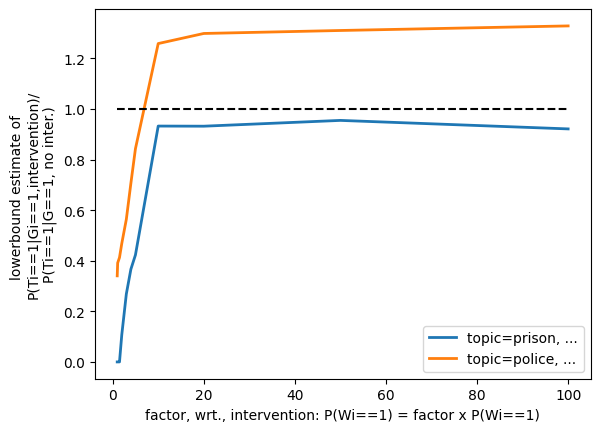

In [378]:
import matplotlib.pyplot as plt

X = [1, 1.1, 1.5, 2, 3, 4, 5, 10, 20, 50, 100]
for name, label in [('S1_black_prison', 'topic=prison, ...'), ('S1_black_police', 'topic=police, ...')]:
    
    Y = [stats_S1[name][x][0][0][0] for x in X] 
    print(list(zip(X, Y)))
    plt.plot(X, Y, label=label, linewidth=2)  # Plotting the first line

# Adding labels and title
plt.plot(X, [1 for x in X], '--', color='black')
plt.xlabel('factor, wrt., intervention: P(Wi==1) = factor x P(Wi==1)')
plt.ylabel('lowerbound estimate of \nP(Ti==1|Gi==1,intervention)/\nP(Ti==1|G==1, no inter.)')

# Adding legend
plt.legend()

# Displaying the plot
plt.savefig("S1_black.png")
plt.show()

[(1, 1.0542233302038862e-09), (1.1, 1.90487270919659e-09), (1.5, 1.8498777112865723e-09), (2, 0.47580184465353276), (3, 0.8633042252509823), (4, 0.9855856534606302), (5, 1.1153076387202263), (10, 1.7474552539959989), (20, 1.6896467681600638), (50, 1.6611699725805553), (100, 1.7320482104802148)]
[(1, 3.156012871665879), (1.1, 3.2422033016975056), (1.5, 3.463906602170843), (2, 3.473666675412582), (3, 3.529292065368288), (4, 3.919712222521916), (5, 4.05815052046542), (10, 4.588902990673551), (20, 4.467592261940876), (50, 4.535455452544914), (100, 4.618588542681456)]


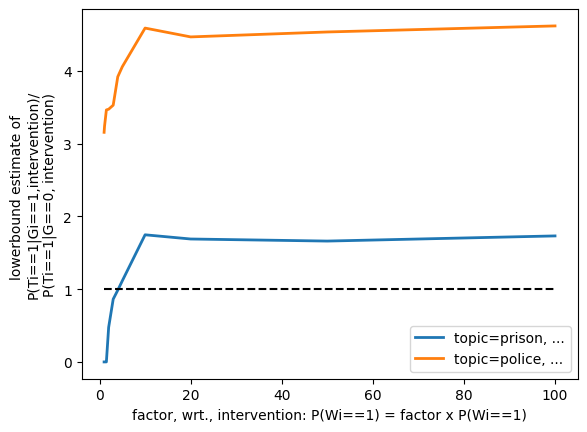

In [393]:
import matplotlib.pyplot as plt

X = [1, 1.1, 1.5, 2, 3, 4, 5, 10, 20, 50, 100]
for name, label in [('S1_black_prison', 'topic=prison, ...'), ('S1_black_police', 'topic=police, ...')]:
    
    Y = [stats_S1[name][x][0][1][0] for x in X] 
    print(list(zip(X, Y)))
    plt.plot(X, Y, label=label, linewidth=2)  # Plotting the first line

# Adding labels and title
plt.plot(X, [1 for x in X], '--', color='black')
plt.xlabel('factor, wrt., intervention: P(Wi==1) = factor x P(Wi==1)')
plt.ylabel('lowerbound estimate of \nP(Ti==1|Gi==1,intervention)/\nP(Ti==1|G==0, intervention)')

# Adding legend
plt.legend()

# Displaying the plot
plt.savefig("S1_black.png")
plt.show()

# Supposition 2 Analysis

### simulate via bernoulli model

In [379]:
from scipy import stats
from scipy.special import expit

def simulate_S2(bernoulli_trace, FACTOR = 1):

    runs = 4000
    n=1000

    sample_subset = az.extract(bernoulli_trace, num_samples=runs)

    pG = sample_subset['P(Gi==1)']
    G_ = np.random.binomial(n=1, p=np.array([pG]*n))  # shape= (n, runs)

    w1 = sample_subset['w1']   
    w2 = sample_subset['w2']
    
    pW = FACTOR*expit(np.tile(w1, (n,1)) + np.tile(w2, (n,1))*G_)  # Intervention
    pW[pW>1]=1

    W_ = np.random.binomial(n=1, p=pW)
    W_[W_>1]=1

    t1 = sample_subset['t1']
    t2 = sample_subset['t2']
    t3 = sample_subset['t3']
    pT = expit(np.tile(t1, (n,1)) + np.tile(t2, (n,1))*W_ + np.tile(t3, (n,1))*G_)
    T_ = np.random.binomial(n=1, p=pT)  # dim = (1000, 4000)

    # pT_given_G1 = pT[G_==1]
    # pT_given_G0 = pT[G_==0]

    # samples of expectations
    pT_given_G1 = (((T_==1) & (G_==1)).sum(axis=0) + 1E-9) / (2E-9 + (G_==1).sum(axis=0))
    pT_given_G0 = (((T_==1) & (G_==0)).sum(axis=0) + 1E-9) / (2E-9 + (G_==0).sum(axis=0))
    
    return pT_given_G1, pT_given_G0


### run the bernoulli simulation wrt., causal model S2

In [380]:
# get the P(T==1|...) values each group and for each topic
stats_S2 = defaultdict(lambda: defaultdict(list))
for fn, name in tqdm([
    ('./causal_analysis_black/S2_prison_jail_prisons.save', 'S2_black_prison'),
    ('./causal_analysis_black/S2_police_cops _police officer_cop .save', 'S2_black_police'),
    ('./causal_analysis_black/S2_abortion_abortions_birth control.save', 'S2_black_abortion'),
    ('./causal_analysis_black/S2_drug testing_drug test.save', 'S2_black_drug'),
    ('./causal_analysis_black/S2_fat people_obese_obesity_overweight_fatties.save', 'S2_black_fat'),
    ('./causal_analysis_black/S2_relationship_attractive_dating.save', 'S2_black_relationship'),
    ('./causal_analysis_black/S2_marijuana_cannabis.save', 'S2_black_marijuana'),
    ('./causal_analysis_black/S2_mental illness_mentally ill.save', 'S2_black_mental'),
    ('./causal_analysis_black/S2_heroin.save', 'S2_black_heroin'),
    ('./causal_analysis_black/S2_addiction_addict _addicts.save', 'S2_black_addict'),
    ('./causal_analysis_n/S2_prison_jail_prisons.save', 'S2_n_prison'),
    ('./causal_analysis_n/S2_police_cops _police officer_cop .save', 'S2_n_police'),
    ('./causal_analysis_n/S2_abortion_abortions_birth control.save', 'S2_n_abortion'),
    ('./causal_analysis_n/S2_drug testing_drug test.save', 'S2_n_drug'),
    ('./causal_analysis_n/S2_fat people_obese_obesity_overweight_fatties.save', 'S2_n_fat'),
    ('./causal_analysis_n/S2_relationship_attractive_dating.save', 'S2_n_relationship'),
    ('./causal_analysis_n/S2_marijuana_cannabis.save', 'S2_n_marijuana'),
    ('./causal_analysis_n/S2_mental illness_mentally ill.save', 'S2_n_mental'),
    ('./causal_analysis_n/S2_heroin.save', 'S2_n_black_heroin'),
    ('./causal_analysis_n/S2_addiction_addict _addicts.save', 'S2_n_addict'),
]):

    # load the model
    with open(fn, 'rb') as f:
        d = cloudpickle.load(f)
    bernoulli_model = d['model']
    bernoulli_trace = d['trace']

    # simulate with no intervention
    pT_G1_non, pT_G0_non = simulate_S2(bernoulli_trace)

    # simulate with various interventious
    for factor in [1, 1.1, 1.5, 2, 3, 4, 5, 10, 20, 50, 100, 1000000]:
        pT_G1_int, pT_G0_int = simulate_S2(bernoulli_trace, FACTOR=factor)

        # stat1 = compat_interval((pT_G1_int*(1-pT_G1_int)) / (1E-9 + pT_G1_non)*(1-pT_G1_non), 0.99) # OR equation 6: i.e., exposure = int, and disease = (Ti==1)
        # stat2 = compat_interval((pT_G1_int)*(1-pT_G1_int) / (1E-9 + pT_G0_int*(1-pT_G0_int)), 0.99) # # OR equation 7: i.e., exposure = (Gi==0) and disease = (Ti==1)

        lb = (1-0.99)/2
        ub = 1-lb

        # Risk Ratio
        RR1 = pT_G1_int / (pT_G1_non + 1E-9)
        stat1 = (np.quantile(RR1, lb), np.quantile(RR1, ub))

        RR2 = pT_G1_int / (pT_G0_int + 1E-9)
        stat2 = (np.quantile(RR2, lb), np.quantile(RR2, ub))

        # odds ratio
        OR1 = (pT_G1_int*(1-pT_G1_int)) / (1E-9 + (pT_G1_non)*(1-pT_G1_non))
        stat1b = (np.quantile(OR1, lb), np.quantile(OR1, ub))

        # odds ratio
        OR2 = (pT_G1_int*(1-pT_G1_int)) / (1E-9 + pT_G0_int*(1-pT_G0_int))
        stat2b = (np.quantile(OR2, lb), np.quantile(OR2, ub))

        stats_S2[name][factor].append((stat1, stat2, stat1b, stat2b))

100%|███████████████████████████████████████████| 20/20 [01:59<00:00,  5.98s/it]


In [381]:
stats_S2

defaultdict(<function __main__.<lambda>()>,
            {'S2_black_prison': defaultdict(list,
                         {1: [((2.092825939732991e-10, 43778378.91675027),
                            (8.223209322259207e-10, 24.37186735961844),
                            (2.1732969691441355e-10, 41846979.84660265),
                            (8.291372581389203e-10, 23.32954568432929))],
                          1.1: [((1.9719594428775632e-10, 38491423.462155156),
                            (7.490981131626221e-10, 21.795950378931927),
                            (2.0453661129207788e-10, 36999388.66155342),
                            (7.561605817598145e-10, 20.761706652755766))],
                          1.5: [((1.8780442547332994e-10, 41352060.44588309),
                            (6.499238347490937e-10, 18.585187160987513),
                            (1.9557850123434308e-10, 39628804.787326254),
                            (6.568460997770662e-10, 17.541109677456387))],
            

### plot eq6

[(1, 2.092825939732991e-10), (1.1, 1.9719594428775632e-10), (1.5, 1.8780442547332994e-10), (2, 1.9599278331509155e-10), (3, 2.1624360419127e-10), (4, 2.9549036621937827e-10), (5, 3.208318461733995e-10), (10, 4.813817348630775e-10), (20, 0.322720768025141), (50, 0.7385252582294021), (100, 1.1142698194957104)]
[(1, 0.32842557570680814), (1.1, 0.3235085360179633), (1.5, 0.344481074372382), (2, 0.3455933476266051), (3, 0.3553768916852838), (4, 0.35203516299278476), (5, 0.3584460379808641), (10, 0.45803893110605964), (20, 0.6257969755645185), (50, 1.2482627694398738), (100, 1.4890359523669239)]


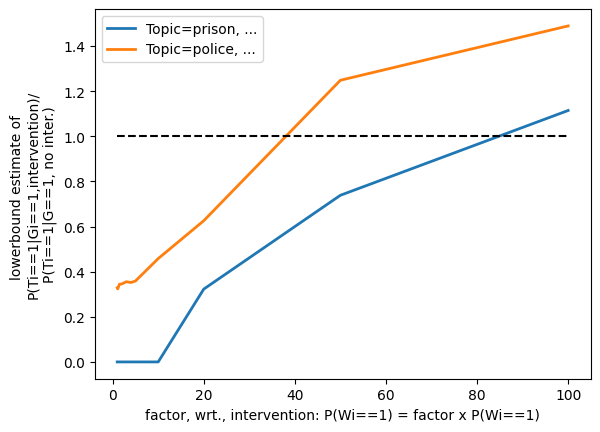

In [382]:
import matplotlib.pyplot as plt

X = [1, 1.1, 1.5, 2, 3, 4, 5, 10, 20, 50, 100]
for name, label in [('S2_black_prison', 'Topic=prison, ...'), ('S2_black_police', 'Topic=police, ...')]:
    
    Y = [stats_S2[name][x][0][0][0] for x in X] 
    print(list(zip(X, Y)))
    plt.plot(X, Y, label=label, linewidth=2)  # Plotting the first line

# Adding labels and title
plt.plot(X, [1 for x in X], '--', color='black')
plt.xlabel('factor, wrt., intervention: P(Wi==1) = factor x P(Wi==1)')
plt.ylabel('lowerbound estimate of \nP(Ti==1|Gi==1,intervention)/\nP(Ti==1|G==1, no inter.)')

# Adding legend
plt.legend()

# Displaying the plot
plt.savefig("S2_black.png")
plt.show()

In [388]:
### plot eq 7

[(1, 8.223209322259207e-10), (1.1, 7.490981131626221e-10), (1.5, 6.499238347490937e-10), (2, 6.193963474715402e-10), (3, 5.111335198519398e-10), (4, 4.759476890817784e-10), (5, 4.77994475740679e-10), (10, 5.432666831712013e-10), (20, 0.3852234744845193), (50, 1.21738689107461), (100, 1.678029247561586)]
[(1, 2.1729073889384725), (1.1, 2.3333332198517556), (1.5, 2.093179024032896), (2, 1.9444213761084288), (3, 1.7443274691028372), (4, 1.5481588112335523), (5, 1.4740975132302179), (10, 1.3463535679545153), (20, 1.9601328346832416), (50, 3.5615434078246775), (100, 4.580372276403915)]


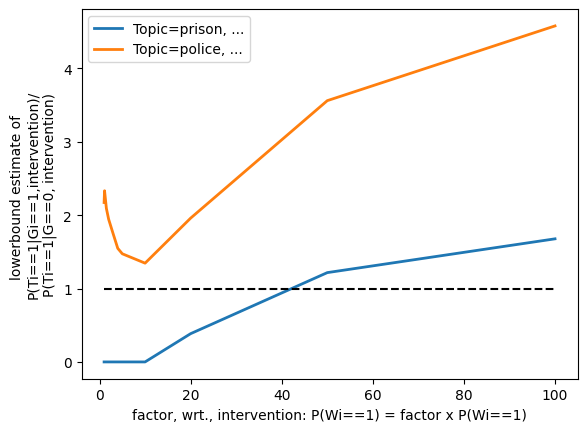

In [391]:
import matplotlib.pyplot as plt

X = [1, 1.1, 1.5, 2, 3, 4, 5, 10, 20, 50, 100]
for name, label in [('S2_black_prison', 'Topic=prison, ...'), ('S2_black_police', 'Topic=police, ...')]:
    
    Y = [stats_S2[name][x][0][1][0] for x in X] 
    print(list(zip(X, Y)))
    plt.plot(X, Y, label=label, linewidth=2)  # Plotting the first line

# Adding labels and title
plt.plot(X, [1 for x in X], '--', color='black')
plt.xlabel('factor, wrt., intervention: P(Wi==1) = factor x P(Wi==1)')
plt.ylabel('lowerbound estimate of \nP(Ti==1|Gi==1,intervention)/\nP(Ti==1|G==0, intervention)')

# Adding legend
plt.legend()

# Displaying the plot
plt.savefig("S2_black.png")
plt.show()

# Supposition 3 Analysis

### simulate via bernoulli model

In [383]:
from scipy import stats
from scipy.special import expit

def simulate_S3(bernoulli_trace, FACTOR = 1):

    runs = 4000
    n=1000

    sample_subset = az.extract(bernoulli_trace, num_samples=runs)

    pW = FACTOR*sample_subset['P(Wi==1)']  # Intervention
    pW[pW>1]=1
    W_ = np.random.binomial(n=1, p=np.array([pW]*n))  # shape= (n, runs)

    g1 = sample_subset['g1']   
    g2 = sample_subset['g2']

    pG = expit(np.tile(g1, (n,1)) + np.tile(g2, (n,1))*W_)  # Interventionsss
    G_ = np.random.binomial(n=1, p=pG)

    t1 = sample_subset['t1']   
    t2 = sample_subset['t2']
    t3 = sample_subset['t3']

    pT = expit(np.tile(t1, (n,1)) + np.tile(t2, (n,1))*G_ + np.tile(t3, (n,1))*W_)
    T_ = np.random.binomial(n=1, p=pT)  # dim = (1000, 4000)

    # samples of expectations
    pT_given_G1 = (((T_==1) & (G_==1)).sum(axis=0) + 1E-9) / (2E-9 + (G_==1).sum(axis=0))
    pT_given_G0 = (((T_==1) & (G_==0)).sum(axis=0) +1E-9) / (2E-9 + (G_==0).sum(axis=0))
    
    return pT_given_G1, pT_given_G0


### run the bernoulli simulation wrt., causal model S3

In [384]:
# get the P(T==1|...) values each group and for each topic
stats_S3 = defaultdict(lambda: defaultdict(list))
for fn, name in tqdm([
    ('./causal_analysis_black/S3_prison_jail_prisons.save', 'S3_black_prison'),
    ('./causal_analysis_black/S3_police_cops _police officer_cop .save', 'S3_black_police'),
    ('./causal_analysis_black/S3_abortion_abortions_birth control.save', 'S3_black_abortion'),
    ('./causal_analysis_black/S3_drug testing_drug test.save', 'S3_black_drug'),
    ('./causal_analysis_black/S3_fat people_obese_obesity_overweight_fatties.save', 'S3_black_fat'),
    ('./causal_analysis_black/S3_relationship_attractive_dating.save', 'S3_black_relationship'),
    ('./causal_analysis_black/S3_marijuana_cannabis.save', 'S3_black_marijuana'),
    ('./causal_analysis_black/S3_mental illness_mentally ill.save', 'S3_black_mental'),
    ('./causal_analysis_black/S3_heroin.save', 'S3_black_heroin'),
    ('./causal_analysis_black/S3_addiction_addict _addicts.save', 'S3_black_addict'),
    ('./causal_analysis_n/S3_prison_jail_prisons.save', 'S3_n_prison'),
    ('./causal_analysis_n/S3_police_cops _police officer_cop .save', 'S3_n_police'),
    ('./causal_analysis_n/S3_abortion_abortions_birth control.save', 'S3_n_abortion'),
    ('./causal_analysis_n/S3_drug testing_drug test.save', 'S3_n_drug'),
    ('./causal_analysis_n/S3_fat people_obese_obesity_overweight_fatties.save', 'S3_n_fat'),
    ('./causal_analysis_n/S3_relationship_attractive_dating.save', 'S3_n_relationship'),
    ('./causal_analysis_n/S3_marijuana_cannabis.save', 'S3_n_marijuana'),
    ('./causal_analysis_n/S3_mental illness_mentally ill.save', 'S3_n_mental'),
    ('./causal_analysis_n/S3_heroin.save', 'S3_n_black_heroin'),
    ('./causal_analysis_n/S3_addiction_addict _addicts.save', 'S3_n_addict'),
]):

    # load the model
    with open(fn, 'rb') as f:
        d = cloudpickle.load(f)
    bernoulli_model = d['model']
    bernoulli_trace = d['trace']

    # simulate with no intervention
    pT_G1_non, pT_G0_non = simulate_S3(bernoulli_trace)

    # simulate with various interventious
    for factor in [1, 1.1, 1.5, 2, 3, 4, 5, 10, 20, 50, 100, 1000000]:
        pT_G1_int, pT_G0_int = simulate_S3(bernoulli_trace, FACTOR=factor)

        lb = (1-0.99)/2
        ub = 1-lb

        # Risk Ratio
        RR1 = pT_G1_int / (pT_G1_non + 1E-9)
        stat1 = (np.quantile(RR1, lb), np.quantile(RR1, ub))

        RR2 = pT_G1_int / (pT_G0_int + 1E-9)
        stat2 = (np.quantile(RR2, lb), np.quantile(RR2, ub))

        # odds ratio
        OR1 = (pT_G1_int*(1-pT_G1_int)) / (1E-9 + (pT_G1_non)*(1-pT_G1_non))
        stat1b = (np.quantile(OR1, lb), np.quantile(OR1, ub))

        # odds ratio
        OR2 = (pT_G1_int*(1-pT_G1_int)) / (1E-9 + pT_G0_int*(1-pT_G0_int))
        stat2b = (np.quantile(OR2, lb), np.quantile(OR2, ub))

        stats_S3[name][factor].append((stat1, stat2, stat1b, stat2b))

100%|███████████████████████████████████████████| 20/20 [01:58<00:00,  5.92s/it]


In [385]:
stats_S3

defaultdict(<function __main__.<lambda>()>,
            {'S3_black_prison': defaultdict(list,
                         {1: [((2.1719735588657393e-10, 38749216.264186665),
                            (7.777424286986708e-10, 21.501457639625666),
                            (2.25713468120602e-10, 37235514.87999968),
                            (7.858252477072556e-10, 20.89425934802283))],
                          1.1: [((1.8040780040619624e-10, 38180233.48658967),
                            (7.310735242204509e-10, 25.85102900931523),
                            (1.8767987896164773e-10, 36711705.60501968),
                            (7.379941555869389e-10, 24.57277594279279))],
                          1.5: [((2.0640616373764214e-10, 38481286.72016728),
                            (6.606700637855656e-10, 20.436829232805998),
                            (2.1600152645564277e-10, 36989582.27144008),
                            (6.697137213085017e-10, 19.23061213901434))],
                

[(1, 0.3172094552515364), (1.1, 0.33301583381781147), (1.5, 0.322485692894224), (2, 0.32702409466321614), (3, 0.3124210144917935), (4, 0.32403117769765183), (5, 0.2609356830517969), (10, 0.3910880807926777), (20, 0.39372929918207694), (50, 1.8123859694286101e-09)]


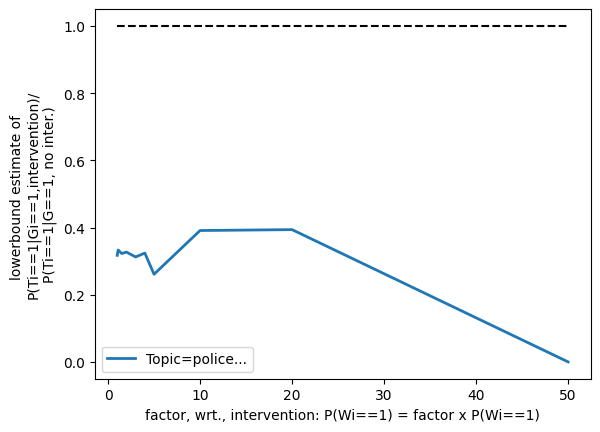

In [387]:
import matplotlib.pyplot as plt

X = [1, 1.1, 1.5, 2, 3, 4, 5, 10, 20, 50]
for name, label in [('S3_black_police', 'Topic=police...')]:
    
    Y = [stats_S3[name][x][0][0][0] for x in X] 
    print(list(zip(X, Y)))
    plt.plot(X, Y, label=label, linewidth=2)  # Plotting the first line

# Adding labels and title
plt.plot(X, [1 for x in X], '--', color='black')
plt.xlabel('factor, wrt., intervention: P(Wi==1) = factor x P(Wi==1)')
plt.ylabel('lowerbound estimate of \nP(Ti==1|Gi==1,intervention)/\nP(Ti==1|G==1, no inter.)')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()